## Checking the performance of quality metric from hembedder 

In [2]:
from setup_cc import *
import cProfile
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import cProfile, pstats, io
from pstats import SortKey

sample_index = cell_dyn.sample(40000).index
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
#sampled_embedded = np.asarray(dm6.loc[sample_index],dtype=np.float16)





In [1]:
#trustworthiness --> sklearn
# distance correlation correlation --> zelf chefffen
# knn-overlap - distance curve and integral
# poincarre


### knn_overlap -> find knn in true space random sample. Then embedding do the same for indices -> jaccard score
__author__ = "Bram van ES", "Huibert-Jan Joosse", "Chontira Chumsaeng"

from scipy.spatial.distance import jaccard, hamming
from scipy.spatial.distance import pdist
import scipy as sc

import numpy as np
from numpy.random import default_rng
from sklearn.manifold import trustworthiness
import dcor
import faiss
import time
import os
from tabulate import tabulate
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed

import ctypes
from ctypes import cdll

import hembedder.utils._cpython._metrics_cy as metrics_cy

from functools import lru_cache
from numba import jit, njit

from tqdm import tqdm

from sklearn.metrics import pairwise_distances, pairwise_distances_chunked

"""
sources:
https://github.com/samueljackson92/coranking/tree/master/src
https://github.com/gdkrmr/coRanking/tree/master/R
"""

# source : https://timsainburg.com/coranking-matrix-python-numba.html
def compute_ranking_matrix_parallel(D):
    """Compute ranking matrix in parallel. Input (D) is distance matrix"""
    # if data is small, no need for parallel
    if len(D) > 1000:
        n_jobs = -1
    else:
        n_jobs = 1
    r1 = Parallel(n_jobs, prefer="threads")(
        delayed(np.argsort)(i)
        for i in tqdm(D.T, desc="computing rank matrix", leave=False)
    )
    r2 = Parallel(n_jobs, prefer="threads")(
        delayed(np.argsort)(i)
        for i in tqdm(r1, desc="computing rank matrix", leave=False)
    )
    # write as a single array
    r2_array = np.zeros((len(r2), len(r2[0])), dtype="int32")
    for i, r2row in enumerate(tqdm(r2, desc="concatenating rank matrix", leave=False)):
        r2_array[i] = r2row
    return r2_array


@njit(fastmath=True)
def populate_Q(Q, i, m, R1, R2):
    """populate coranking matrix using numba for speed"""
    for j in range(m):
        k = R1[i, j]
        l = R2[i, j]
        Q[k, l] += 1
    return Q


def iterate_compute_distances(data):
    """Compute pairwise distance matrix iteratively, so we can see progress"""
    n = len(data)
    D = np.zeros((n, n), dtype="float32")
    col = 0
    for i, distances in enumerate(
        pairwise_distances_chunked(data,metric = 'manhattan', n_jobs=-1),
    ):
        D[col : col + len(distances)] = distances
    return D


def compute_coranking_matrix(data_ld, data_hd=None, D_hd=None, leave = True):
    """Compute the full coranking matrix"""

    # compute pairwise probabilities
    if D_hd is None:
        D_hd = iterate_compute_distances(data_hd)

    D_ld = iterate_compute_distances(data_ld)
    n = len(D_ld)
    # compute the ranking matrix for high and low D
    rm_hd = compute_ranking_matrix_parallel(D_hd)
    rm_ld = compute_ranking_matrix_parallel(D_ld)

    # compute coranking matrix from_ranking matrix
    m = len(rm_hd)
    Q = np.zeros(rm_hd.shape, dtype="int16")
    for i in tqdm(range(m), desc="computing coranking matrix", leave = leave):
        Q = populate_Q(Q, i, m, rm_hd, rm_ld)

    Q = Q[1:, 1:]
    return Q


@njit(fastmath=True)
def qnx_crm(Q: np.array, n_neighbours: int):
    """Average Normalized Agreement Between K-ary Neighborhoods (QNX)
    # QNX measures the degree to which an embedding preserves the local
    # neighborhood around each observation. For a value of K, the K closest
    # neighbors of each observation are retrieved in the input and output space.
    # For each observation, the number of shared neighbors can vary between 0
    # and K. QNX is simply the average value of the number of shared neighbors,
    # normalized by K, so that if the neighborhoods are perfectly preserved, QNX
    # is 1, and if there is no neighborhood preservation, QNX is 0.
    #
    # For a random embedding, the expected value of QNX is approximately
    # K / (N - 1) where N is the number of observations. Using RNX
    # (\code{rnx_crm}) removes this dependency on K and the number of
    # observations.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return QNX for \code{k}.
    # @references
    # Lee, J. A., & Verleysen, M. (2009).
    # Quality assessment of dimensionality reduction: Rank-based criteria.
    # \emph{Neurocomputing}, \emph{72(7)}, 1431-1443.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    source: https://timsainburg.com/coranking-matrix-python-numba.html
    """
    qnx_crm_sum = np.sum(Q[:n_neighbours, :n_neighbours])
    return qnx_crm_sum / (n_neighbours * len(Q))


@njit(fastmath=True)
def rnx_crm(Q: np.array, n_neighbours: int):
    """Rescaled Agreement Between K-ary Neighborhoods (RNX)
    # RNX is a scaled version of QNX which measures the agreement between two
    # embeddings in terms of the shared number of k-nearest neighbors for each
    # observation. RNX gives a value of 1 if the neighbors are all preserved
    # perfectly and a value of 0 for a random embedding.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return RNX for \code{k}.
    # @references
    # Lee, J. A., Renard, E., Bernard, G., Dupont, P., & Verleysen, M. (2013).
    # Type 1 and 2 mixtures of Kullback-Leibler divergences as cost functions in
    # dimensionality reduction based on similarity preservation.
    # \emph{Neurocomputing}, \emph{112}, 92-108.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    source: https://timsainburg.com/coranking-matrix-python-numba.html
    """
    n = len(Q)
    return ((qnx_crm(Q, n_neighbours) * (n - 1)) - n_neighbours) / (
        n - 1 - n_neighbours
    )


@njit(fastmath=True)
def rnx_auc_crm(Q: np.array):
    """Area Under the RNX Curve
    # The RNX curve is formed by calculating the \code{rnx_crm} metric for
    # different sizes of neighborhood. Each value of RNX is scaled according to
    # the natural log of the neighborhood size, to give a higher weight to smaller
    # neighborhoods. An AUC of 1 indicates perfect neighborhood preservation, an
    # AUC of 0 is due to random results.
    #
    # param crm Co-ranking matrix.
    # return Area under the curve.
    # references
    # Lee, J. A., Peluffo-Ordo'nez, D. H., & Verleysen, M. (2015).
    # Multi-scale similarities in stochastic neighbour embedding: Reducing
    # dimensionality while preserving both local and global structure.
    # \emph{Neurocomputing}, \emph{169}, 246-261.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    source: https://timsainburg.com/coranking-matrix-python-numba.html
    """
    n = len(Q)
    num = 0
    den = 0

    qnx_crm_sum = 0
    for k in range(1, n - 2):
        # for k in (range(1, n - 2)):
        qnx_crm_sum += (
            np.sum(Q[(k - 1), :k]) + np.sum(Q[:k, (k - 1)]) - Q[(k - 1), (k - 1)]
        )
        qnx_crm = qnx_crm_sum / (k * len(Q))
        rnx_crm = ((qnx_crm * (n - 1)) - k) / (n - 1 - k)
        num += rnx_crm / k
        den += 1 / k
    return num / den


class CDEmbeddingPerformance:
    """
    Class for calulating the embedding quality. Metrics include trustworthiness,
    Knn overlap, distance correlation, and random triplet scores
    """

    def __init__(
        self,
        metric="euclidean",
        n_neighbours: int = 50,
        knn_dist: str = "jaccard",
        dcor_level: int = 2,
        num_triplets: int = 5,
        dtype=np.float32,
        scaled: bool = False,
    ):
        """
        Setting up parameters for the quality metircs

        Paramters
        ---------
        metric: string or function
            distance metric for trustworiness and distance correlation
        n_neighbours:int
            number of neighbours for trustworiness and knn overlap scores
        knn_dist:string
            distance metric for calculating overlap between neighbours in knn overlap.
            'hamming' or 'jaccard'
        dcor_level:int
            depth of correlation; 1 is distance correlation of data, 2 is distance
            correlation of distances
        num_triplets:int
            paramter for random triplets calculation.
        dtype: float
            for setting type of np.array to work with. If the data set is
            too large use np.float16
        scaled: bool
            whether to use a scaled version of Qnx
        """
        self.metric = metric
        self.n_neighbours = n_neighbours
        self.knn_dist = knn_dist
        self.num_triplets = num_triplets
        self.dtype = dtype
        self.dcor_level = dcor_level
        self.scaled = scaled

    def _get_coranking_matrix(self, X_org: np.array, X_emb: np.array, backend="numba"):
        """
        Function for returning the coranking matrix of the original data and the embedded data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array

        Returns
        -----------
        coranking matrix as np.array
        """

        if backend == "python":
            # source: https://github.com/samueljackson92/coranking/blob/master/coranking/_coranking.py
            n, m = X_org.shape
            high_distance = sc.spatial.distance.squareform(
                sc.spatial.distance.pdist(X_org)
            )
            low_distance = sc.spatial.distance.squareform(
                sc.spatial.distance.pdist(X_emb)
            )

            high_ranking = high_distance.argsort(axis=1).argsort(axis=1)
            low_ranking = low_distance.argsort(axis=1).argsort(axis=1)

            Q, xedges, yedges = np.histogram2d(
                high_ranking.flatten(), low_ranking.flatten(), bins=n
            )
            Q = Q.astype(np.int32)
            return Q[:1, :1]
        elif backend == "numba":
            Q = compute_coranking_matrix(data_ld=X_emb, data_hd=X_org).astype(np.int32)
            return Q
        elif backend == "cython":
            Q = metrics_cy.Qmatrix(X_org, X_emb)
            return Q
        elif backend == "ctype":
            script_path = "/".join(str(os.path.abspath(__file__)).split("/")[:-1])
            coranking = cdll.LoadLibrary(
                os.path.join(script_path, "_ctypes/coranking.so")
            )
            # coranking = ctypes.CDLL(os.path.join(script_path, "_ctypes/coranking.so"))
            # from hembedder.utils._ctypes import coranking

            # print("Making ravelled arrays")
            # X_org_vector = np.ravel(X_org, order="F")
            # X_emb_vector = np.ravel(X_emb, order="F")

            print("Making C-types variables")
            c_double_C = ctypes.POINTER(ctypes.c_double)
            X_org_C = X_org.ctypes.data_as(c_double_C)
            X_emb_C = X_emb.ctypes.data_as(c_double_C)

            # print("Setting up C-types function argument and return types")
            coranking.euclidean.restype = None
            coranking.euclidean.argtypes = [
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_double),
            ]

            print("Calling Ctype function on original data")
            N = X_org.shape[0]
            Dor = X_org.shape[1]

            DD = np.zeros((N, N), dtype=self.dtype)
            DD_ptr = DD.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            coranking.euclidean(X_org_C, N, Dor, DD_ptr)
            high_distance = DD.copy()

            print("Calling Ctype function on embedded data")
            Demb = X_emb.shape[1]

            DD = np.zeros((N, N), dtype=self.dtype)
            DD_ptr = DD.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
            coranking.euclidean(X_emb_C, N, Demb, DD_ptr)
            low_distance = DD.copy()

            print("Calling Ctype function on rankmatrix, original")
            coranking.rankmatrix.restype = None
            coranking.rankmatrix.argtypes = [
                ctypes.POINTER(ctypes.c_double),
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_int),
            ]

            Rm = np.zeros((N, N), dtype=np.int32)
            Rm_ptr = Rm.ctypes.data_as(ctypes.POINTER(ctypes.c_int))
            coranking.rankmatrix(
                high_distance.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                N,
                Rm_ptr,
            )
            high_ranking = Rm.copy()

            print("Calling Ctype function on rankmatrix, embedded")
            Rm = np.zeros((N, N), dtype=np.int32)
            Rm_ptr = Rm.ctypes.data_as(ctypes.POINTER(ctypes.c_int))
            coranking.rankmatrix(
                low_distance.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
                N,
                Rm_ptr,
            )
            low_ranking = Rm.copy()

            ##
            coranking.coranking.restype = None
            coranking.coranking.argtypes = [
                ctypes.POINTER(ctypes.c_int),
                ctypes.POINTER(ctypes.c_int),
                ctypes.c_int,
                ctypes.POINTER(ctypes.c_int),
            ]

            print("Calling Ctype function on Qmatrix")
            Q = np.zeros((N - 1, N - 1), dtype=np.int32)
            Q_ptr = Q.ctypes.data_as(ctypes.POINTER(ctypes.c_int))
            coranking.coranking(
                high_ranking.ctypes.data_as(ctypes.POINTER(ctypes.c_int)),
                low_ranking.ctypes.data_as(ctypes.POINTER(ctypes.c_int)),
                N,
                Q_ptr,
            )
            return Q
        else:
            raise ValueError("Backend not supported")

    def _return_Qnx(self, X_org: np.array, X_emb: np.array, Q: np.array = None):
        """
        Function for returning Qnx score from the original data and the embedded data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        Qnx score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.Qnx(Q, self.n_neighbours, self.scaled)

    def _return_Qtrustworthiness(
        self, X_org: np.array, X_emb: np.array, Q: np.array = None
    ):
        """
        Function for returning trustworthiness score from sklearn.manifold.

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        Trustworthiness score between 0 and 1. Higher means better
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.trustworthiness(Q, self.n_neighbours)

    def _return_Qcontinuity(self, X_org: np.array, X_emb: np.array, Q: np.array = None):
        """
        Function for returning trustworthiness score from sklearn.manifold.

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        Continuity score between 0 and 1. Higher means better
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.continuity(Q, self.n_neighbours)

    def _return_LCMC(self, X_org: np.array, X_emb: np.array, Q: np.array = None):
        """
        Function for returning LCMC score from the original data and the embedded data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        LCMC score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.LCMC(Q, self.n_neighbours)

    def _return_nMRRE(self, X_org: np.array, X_emb: np.array, Q: np.array = None):
        """
        Function for returning LCMC score from the original data and the embedded data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        nMRRE score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.nMRRE(Q, self.n_neighbours)

    def _return_vMRRE(self, X_org: np.array, X_emb: np.array, Q: np.array = None):
        """
        Function for returning LCMC score from the original data and the embedded data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        vMRRE score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return metrics_cy.vMRRE(Q, self.n_neighbours)

    def _return_qnx_crm(self, X_org: np.array, X_emb: np.array,Q: np.array=None):
        """
        Function for returning qnx_crm score from the coranking matrix

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        qnx_crm score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return qnx_crm(Q, self.n_neighbours)

    def _return_rnx_crm(self, X_org: np.array, X_emb: np.array, Q: np.array=None):
        """
        Function for returning rnx_crm score from the coranking matrix

        Parameters
        ----------
       X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        rnx_crm score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return rnx_crm(Q, self.n_neighbours)

    def _return_rnx_auc_crm(self, X_org: np.array, X_emb: np.array, Q: np.array=None):
        """
        Function for returning rnx_auc_crm score from the coranking matrix

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        Q:np.array
            the coranking matrix as np.array

        Returns
        -----------
        rnx_auc_crm score as float
        """
        if Q is None:
            Q = self._get_coranking_matrix(X_org, X_emb)
        return rnx_auc_crm(Q)

    def _return_trustworthiness(self, X_org: np.array, X_emb: np.array):
        """
        Function for returning trustworthiness score from sklearn.manifold.

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array

        Returns
        -----------
        Trustworithiness score between 0 and 1. Higher means better
        """
        return trustworthiness(
            X_org, X_emb, n_neighbors=self.n_neighbours, metric=self.metric
        )

    @staticmethod
    def _create_knn_search(X, k, dtype):
        """
        HELPER function for knn_overlap
        """
        index = faiss.IndexFlatL2(X.shape[1])
        index.add(X.astype(dtype))
        D, I = index.search(X.astype(dtype), k)
        return D, I

    def _return_knn_overlap(
        self, X_org: np.array, X_emb: np.array, knn_return_median: bool = True
    ):
        """
        Function for returning nearest neighbourhood overlap score.
        Overlap between the high dimension and low dimension data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        knn_return_median:bool
            whether to return the median of the knn overlap scores.
            This should be true if knn is to be used with other methods here.

        Returns
        -----------
        knn overlap score between 0 and 1. Lower means better
        """
        D, I = self._create_knn_search(X_org, self.n_neighbours, self.dtype)
        D_emb, I_emb = self._create_knn_search(X_emb, self.n_neighbours, self.dtype)
        ds_arry = np.zeros(I.shape[0])
        dist = None
        if self.knn_dist == "jaccard":
            dist = jaccard
        elif self.knn_dist == "hamming":
            dist = hamming
        else:
            raise Exception(
                f"{self.knn_dist} is not a recognised distance"
                + " measure for KNN overlap. Please use 'jaccard' or 'hamming'"
            )
        for i in range(I.shape[0]):
            ds_arry[i] = dist(I[i, :], I_emb[i, :])
        return np.median(ds_arry) if knn_return_median else ds_arry

    def _return_distance_correlation(self, X_org: np.array, X_emb: np.array):
        """
        Function for returning distance correlation from dcor between the
        high dimension and low dimension data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array

        Returns
        -----------
        distance correlation score between 0 and 1. Higher means better
        """
        if self.dcor_level == 1:
            return dcor.distance_correlation(X_org, X_emb)
        elif self.dcor_level == 2:
            return dcor.distance_correlation(
                pdist(X_org, metric="cityblock"), pdist(X_emb, metric="cityblock")
            )
        else:
            raise Exception(
                f"{self.dcor_level} is not a recognised level for"
                + " distance correlation. Please use 1 or 2"
            )

    def _return_dynamic_distance_correlation(
        self, X_org: np.array, X_emb: np.array, n_bins=5
    ):
        """
        Function for returning dynamic distance correlation from dcor between the
        high dimension and low dimension data

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        n_bins: int
            the number of quantile bins to extract the distance-distance correlation
        Returns
        -----------
        dynamic distance correlation score between 0 and 1. Higher means better
        """

        dist_org = pdist(X_org, metric="cityblock")
        dist_emb = pdist(X_emb, metric="cityblock")

        d_min = min(dist_org)
        d_max = max(dist_org)
        d_bins = np.quantile(dist_org, np.linspace(0, 1, n_bins + 1))
        d_ranges = list(zip(d_bins[:-1], d_bins[1:]))
        res = []
        for d_range in d_ranges:
            idx = (dist_org >= d_range[0]) & (dist_org <= d_range[1])
            res.append(dcor.distance_correlation(dist_emb[idx], dist_org[idx]))
        return res

    @staticmethod
    def calculate_distance_random_triplets(X: np.array, anchors, triplets):
        """
        HELPER function for random_triplet_eval to calculate distance
        for X and generate the labels
        """
        b = np.broadcast(anchors, triplets)
        distances = np.empty(b.shape)
        distances.flat = [np.linalg.norm(X[u] - X[v]) for (u, v) in b]
        labels = distances[:, :, 0] < distances[:, :, 1]
        return labels

    @staticmethod
    def calculate_anchors_and_triplets(X: np.array, num_triplets: int):
        """
        HELPER function for random_triplet_eval to create the
        achors and triplets for evaluating thetriplets violation
        """
        anchors = np.arange(X.shape[0])
        rng = default_rng()
        triplets = rng.choice(anchors, (X.shape[0], num_triplets, 2))
        triplet_labels = np.zeros((X.shape[0], num_triplets))
        anchors = anchors.reshape((-1, 1, 1))
        return anchors, triplets

    def random_triplet_eval(self, X_org: np.array, X_emb: np.array):
        """
        Author: Haiyang Huang https://github.com/hyhuang00/scRNA-DR2020/blob/main/experiments/run_eval.py
        This is a function that is used to evaluate the lower dimension embedding.
        An triplet satisfaction score is calculated by evaluating how many randomly
        selected triplets have been violated. Each point will generate 5 triplets.

        Parameters
        ----------
            X_org: A numpy array with the shape [N, p]. The higher dimension embedding
            of some dataset. Expected to have some clusters.
            X_emb: A numpy array with the shape [N, k]. The lower dimension embedding
                of some dataset. Expected to have some clusters as well.

        Returns
        ----------
            acc: The score generated by the algorithm.
        """
        # Sampling Triplets
        # Five triplet per point
        anchors, triplets = self.calculate_anchors_and_triplets(
            X_org, self.num_triplets
        )

        # Calculate the distances and generate labels
        labels = self.calculate_distance_random_triplets(X_org, anchors, triplets)

        # Calculate distances for LD
        pred_vals = self.calculate_distance_random_triplets(X_emb, anchors, triplets)

        # Compare the labels and return the accuracy
        correct = np.sum(pred_vals == labels)
        acc = correct / X_org.shape[0] / self.num_triplets
        return acc

    def neighbor_kept_ratio_eval(self, X_org: np.array, X_emb: np.array):
        """
        Author: Haiyang Huang https://github.com/hyhuang00/scRNA-DR2020/blob/main/experiments/run_eval.py
        This is a function that evaluates the local structure preservation.
        A nearest neighbor set is constructed on both the high dimensional space and
        the low dimensional space.

        Input:
            X_org: A numpy array with the shape [N, p]. The higher dimension embedding
            of some dataset. Expected to have some clusters.
            X_emb: A numpy array with the shape [N, k]. The lower dimension embedding
                of some dataset. Expected to have some clusters as well.

        Output:
            acc: The score generated by the algorithm.
        """
        nn_hd = NearestNeighbors(n_neighbors=self.n_neighbours + 1)
        nn_ld = NearestNeighbors(n_neighbors=self.n_neighbours + 1)
        nn_hd.fit(X_org)
        nn_ld.fit(X_emb)
        # Construct a k-neighbors graph, where 1 indicates a neighbor relationship
        # and 0 means otherwise, resulting in a graph of the shape n * n
        graph_hd = nn_hd.kneighbors_graph(X_org).toarray()
        graph_hd -= np.eye(X_org.shape[0])  # Removing diagonal
        graph_ld = nn_ld.kneighbors_graph(X_emb).toarray()
        graph_ld -= np.eye(X_org.shape[0])  # Removing diagonal
        neighbor_kept = np.sum(graph_hd * graph_ld).astype(self.dtype)
        neighbor_kept_ratio = neighbor_kept / self.n_neighbours / X_org.shape[0]
        return neighbor_kept_ratio

    def score(
        self,
        X_org: np.array,
        X_emb: np.array,
        subsampling: int = 1000,
        num_iter: int = 10,
        return_results: bool = False,
    ):
        """
        Return embedding trustworithness, knn overlap, distance correlation,
        and random triplets scores.

        Parameters
        ----------
        X_org:np.array
            the original dataset as np.array
        X_emb:np.array
            the embedded data as np.array
        subsampling:int
            the number of samples for the data to be subsampled down to
        num_iter:
            the amount of iteration for the algorithms to cycle through
            for calculating the scores
        return_results:bool
            whether to return the results as dictionary

        Returns
        ----------
        final_results:dict, optional
            the calculated results in a dictionary.

        """
        evaluators = {
            "Trustworthiness": self._return_trustworthiness,
            "Knn overlap": self._return_knn_overlap,
            "Distance correlation": self._return_distance_correlation,
            "Random triplets": self.random_triplet_eval,
            "neighbor kept ratio": self.neighbor_kept_ratio_eval,
        }
        final_results = score_subsampling(
            X_org,
            X_emb,
            evaluators=evaluators,
            size=subsampling,
            num_iter=num_iter,
            verbose=True,
            return_dict=True,
        )
        if return_results:
            return final_results


def metrics_scores_iter(
    x: np.array,
    output: np.array,
    evaluators: dict,
    verbose: bool = True,
    return_dict: bool = False,
    **args
):
    """Calculates scores for embedder using different metrics (evaluators).

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.
    verbose: bool, optional
        whether to print the results.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = {}
    for name, metric in evaluators.items():
        results.update({name: metric(x, output,**args)})
    if verbose:
        print_metric_scores(results)
    if return_dict:
        return results


def print_metric_scores(results: dict):
    """Print mertic scores in a table format.

    Parameters
    ---------
    results: dict
            dictionary of results to be printed in a table format.
    """
    tab = []
    for metric, score in results.items():
        tab.append([metric, score])
    print(tabulate(tab, headers=["Metric", "Score"]))
    print("\n")


def print_means_metric_scores(results: dict):
    """Print means of metric scores in a table format with standard deviation.

    Parameters
    ---------
    results: dict
            dictionary of results to be printed in a table format.
    """
    tab = []
    for metric, score in results.items():
        tab.append([metric, score[0][0], score[0][1]])
    print(tabulate(tab, headers=["Metric", "Mean", "Standard deviation"]))
    print("\n")


def get_results(args):
    """HELPER function for parallelisation of this function in score_subsampling"""
    sample = np.random.choice(np.arange(len(args["X"])), size=args["size"])
    X_org_sub = args["X"][sample, :]
    X_emb_sub = args["output"][sample, :]
    results = metrics_scores_iter(
        X_org_sub, X_emb_sub, args["evaluators"], verbose=False, return_dict=True
    )
    for name, score in results.items():
        args["results"][name].append(score)
    return args["results"]


def score_subsampling(
    X: np.array,
    output: np.array,
    evaluators: dict,
    size: int = 1000,
    num_iter: int = 10,
    verbose: bool = True,
    return_dict: bool = False,
):
    """Calculates quality metric scores with subsampling to reduce processing time.

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.
    size:int
        the number of samples for the data to be subsampled down to
    num_iter:
        the amount of iteration for the algorithms to cycle through for calculating the scores
    verbose: bool, optional
        whether to print the results.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = defaultdict(list)
    method_start = time.time()
    parallel_param = {
        "X": X,
        "output": output,
        "evaluators": evaluators,
        "size": size,
        "results": results,
    }
    results = Parallel(n_jobs=8, verbose=False, pre_dispatch="1.5*n_jobs")(
        delayed(get_results)((parallel_param)) for _ in range(num_iter)
    )

    results_dict = defaultdict(list)
    for i in range(len(results)):
        for k, v in results[i].items():
            results_dict[k].append(v)

    final_results = defaultdict(list)
    for name, scores in results_dict.items():
        final_results[name].append([np.mean(scores), np.std(scores)])
    if verbose:
        print_means_metric_scores(final_results)
        print(f"Supsampling of {size} samples for {num_iter} rounds each")
        print(f"Time taken {round((time.time()-method_start)/60, 2)} minutes")
    if return_dict:
        return final_results



In [3]:
from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

def get_scores(embedded_info): 
    #Get performance metrics for each subsampled embedder
    evaluate_n_n_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, n_neighbours=15, metric='manhattan')
    evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan')

    evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
            'dcor_1': evaluate._return_distance_correlation,
            'neighbor_kept_50' : evaluate.neighbor_kept_ratio_eval,
            'neighbor_kept' : evaluate_n_n_default.neighbor_kept_ratio_eval,
            'dcor_2': evaluate_n_n_default._return_distance_correlation,
            'Trustworthiness': evaluate._return_trustworthiness,
            'LCMC_Q_matrix': evaluate._return_LCMC,
            'Trustworthiness_Q_matrix': evaluate._return_Qtrustworthiness,
            'Continuit_Q_matrix':  evaluate._return_Qcontinuity,
            'nMRRE_Q_matrix' : evaluate._return_nMRRE,
            'vMRRE_Q_matrix' : evaluate._return_vMRRE,
            'Qnx_crm_Q_matrix': evaluate._return_qnx_crm,
            'Rnx_crm_Q_matrix': evaluate._return_rnx_crm,
            'Qnx_auc_crm_Q_matrix': evaluate._return_rnx_auc_crm}
    embedded_info.update({'evaluators': evaluators})
    scores = metrics_scores_iter(**embedded_info)
    return scores

def get_embedded_data(X,parameter:dict, embedder,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    X = np.asarray(X, dtype=np.float32)
    embedded_data = []
    times = []
    for iter in range(num_iter):
        start = time.time()
        sub = numpy_sampling(X, subsampling)
        # Evaluate randomly selected hyperparameters
        CD_scaled = sub.copy()
    
        scaler = StandardScaler()
        CD_scaled = scaler.fit_transform(sub)
        # Create a dictionary for later reference in multi-thread
        indexes_metrics= subsampling_return_indexes(sub, 5000)
        emb_dict = {"original" : sub[indexes_metrics],
                    "embedded" : embedder(**parameter).fit_transform(CD_scaled).astype(np.float32)[indexes_metrics]}
        embedded_data.append(emb_dict)
        #times.append(time.time()-start)
    return embedded_data

def get_embedded_without_embedding(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = []
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"x" : X[sample_index],
                    "output" : X_embedded[sample_index],
                    "Q":compute_coranking_matrix(X[sample_index],\
                    X_embedded[sample_index], leave = False).astype(np.int32)}
        embedded_data.append(emb_dict)
        
    return embedded_data

def metrics_scores_iter(
    x: np.array,
    output: np.array,
    evaluators: dict,
    **args
):
    """Calculates scores for embedder using different metrics (evaluators).

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = {}
    for name, metric in evaluators.items():
        if("Q" in args.keys() and "Q_matrix" in name):
            results.update({name: metric(x, output,args["Q"])})
        else:
            results.update({name: metric(x, output)})
    return results


def get_embedded_without_embedding_queue(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = queue.Queue()
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        print(len(sample_index))
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"original" : X[sample_index],
                    "embedded" : X_embedded[sample_index]}
        embedded_data.put(emb_dict)
        
    return embedded_data

def numpy_sampling(X, subsampling):  
    n_data = len(X) 
    idx = np.arange(n_data) 
    np.random.shuffle(idx) 
    return X[idx[: subsampling],:] 

def subsampling_return_indexes(X, subsampling):
    rand = np.random.default_rng()
    n_data = len(X) 
    subsampling = min(n_data, subsampling) 
    return  rand.choice(np.arange(n_data), size=subsampling, replace=False)

In [4]:
parameter = {"n_components":30}
#embedded_data_queue = get_embedded_without_embedding_queue(cell_dyn,dm6,10,10000,evaluators)
embedded_data = get_embedded_without_embedding(cell_dyn,dm6,10,1000)

In [8]:
#alculating performance for the embedded data using thread pool
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(10)
scores=pool.map(get_scores, (x for x in embedded_data))
pool.close()
pool.join()

In [11]:

#sample_index = cell_dyn.sample(1000).index
print(sample_index[0:10])
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
sampled_emb = np.asarray(dm6.loc[sample_index], dtype=np.float32)
evaluate = CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=50,dcor_level=1,metric='manhattan')
Qmatrix = evaluate._get_coranking_matrix(
    X_org=data_original, X_emb=data_embedding, backend="numba"
)
print("Neigbor kept:",evaluate.neighbor_kept_ratio_eval(sampled_cd,sampled_emb))
print("Random triplet:",evaluate.random_triplet_eval(sampled_cd,sampled_emb))
print("Data correlation:",evaluate._return_distance_correlation(sampled_cd,sampled_emb))
print('LCMC_Q_matrix', evaluate._return_LCMC(sampled_cd,sampled_emb,Qmatrix))
print('Trustworthiness_Q_matrix', evaluate._return_Qtrustworthiness(sampled_cd,sampled_emb,Qmatrix))
print('Continuit_Q_matrix',  evaluate._return_Qcontinuity(sampled_cd,sampled_emb,Qmatrix))
print('nMRRE_Q_matrix' , evaluate._return_nMRRE(sampled_cd,sampled_emb,Qmatrix))
print('vMRRE_Q_matrix' , evaluate._return_vMRRE(sampled_cd,sampled_emb,Qmatrix))
print('Qnx_crm_Q_matrix', evaluate._return_qnx_crm(sampled_cd,sampled_emb,Qmatrix))
print('Rnx_crm_Q_matrix', evaluate._return_rnx_crm(sampled_cd,sampled_emb,Qmatrix))
print('Qnx_auc_crm_Q_matrix', evaluate._return_rnx_auc_crm(sampled_cd,sampled_emb,Qmatrix))

Int64Index([  75045, 1727687, 2620458,  964834, 1659376, 1400305,  447668,
             208951, 2980306, 2159659],
           dtype='int64')


NameError: name 'data_original' is not defined

In [221]:
sample_index = cell_dyn_with_labels.sample(50000).index
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
indexes_metrics= subsampling_return_indexes(sampled_cd, 10000)
age = np.array(cell_dyn_with_labels.age.loc[sample_index])

In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import trimap
from sklearn.decomposition import PCA
import pacmap


metric = "manhattan"

embedder_3 = umap.UMAP(n_components=3,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=None, min_dist=0.0)

embedder_6 = umap.UMAP(n_components=6,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=None, min_dist=0.0)

embedder_15 = umap.UMAP(n_components=15,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0)

embedder_30 = umap.UMAP(n_components=30,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0)

embedder_60 = umap.UMAP(n_components=60,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0,)


trimap_model_3 = trimap.TRIMAP(n_dims=3,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_6 = trimap.TRIMAP(n_dims=6,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_15 = trimap.TRIMAP(n_dims=15,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_30 = trimap.TRIMAP(n_dims=30,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_60 = trimap.TRIMAP(n_dims=60,n_inliers=50,n_outliers=15, n_random=10, distance=metric)

pacmap_model_3 = pacmap.PaCMAP(n_components=3,n_neighbors=100, distance=metric,MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_6 = pacmap.PaCMAP(n_components=6,n_neighbors=100, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_15 = pacmap.PaCMAP(n_components=15,n_neighbors=100, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_30 = pacmap.PaCMAP(n_components=30,n_neighbors=100, distance=metric, MN_ratio=0.5, FP_ratio=1.5)


pca_model_3 = PCA(n_components=3,whiten=False)
pca_model_6 = PCA(n_components=6,whiten=False)
pca_model_15 = PCA(n_components=15,whiten=False)
pca_model_30 = PCA(n_components=30,whiten=False)
pca_model_60 = PCA(n_components=60,whiten=False)




## for loop per model

### UMAP

In [223]:
from scipy.signal import resample
performance_dict_umap = {}
for model in tqdm([embedder_3, embedder_6, embedder_15,embedder_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_umap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [1:04:16<00:00, 964.15s/it] 


In [224]:
import json

with open("../data/umap_performance.json","w") as f:
    json.dump(performance_dict_umap,f)

### TriMAP

In [225]:
from scipy.signal import resample
performance_dict_trimap = {}
for model in tqdm([trimap_model_3, trimap_model_6, trimap_model_15,trimap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_trimap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [2:05:41<00:00, 1885.37s/it]


In [226]:
with open("../data/trimap_performance.json","w") as f:
    json.dump(performance_dict_trimap,f)

### pacmap

In [227]:
performance_dict_pacmap = {}

for model in tqdm([pacmap_model_3, pacmap_model_6, pacmap_model_15, pacmap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pacmap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),
            ('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix),
            ('Qnx_crm',Qnx_crm_Q_matrix), ('rnx_crm',Rnx_crm_Q_matrix), 
            ('Qnx_auc',Qnx_auc_crm_Q_matrix)
            ]
        })
    


100%|██████████| 4/4 [49:06<00:00, 736.68s/it]


In [228]:
with open("../data/pacmap_performance.json","w") as f:
    json.dump(performance_dict_pacmap,f)

### PCA

In [229]:
from scipy.signal import resample
performance_dict_pca = {}
for model in tqdm([pca_model_3,pca_model_6, pca_model_15,pca_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.transform(sampled_cd[indexes_metrics]).astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pca.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [02:26<00:00, 36.67s/it]


In [230]:
with open("../data/pca_performance.json","w") as f:
    json.dump(performance_dict_pca,f)

### comparing results

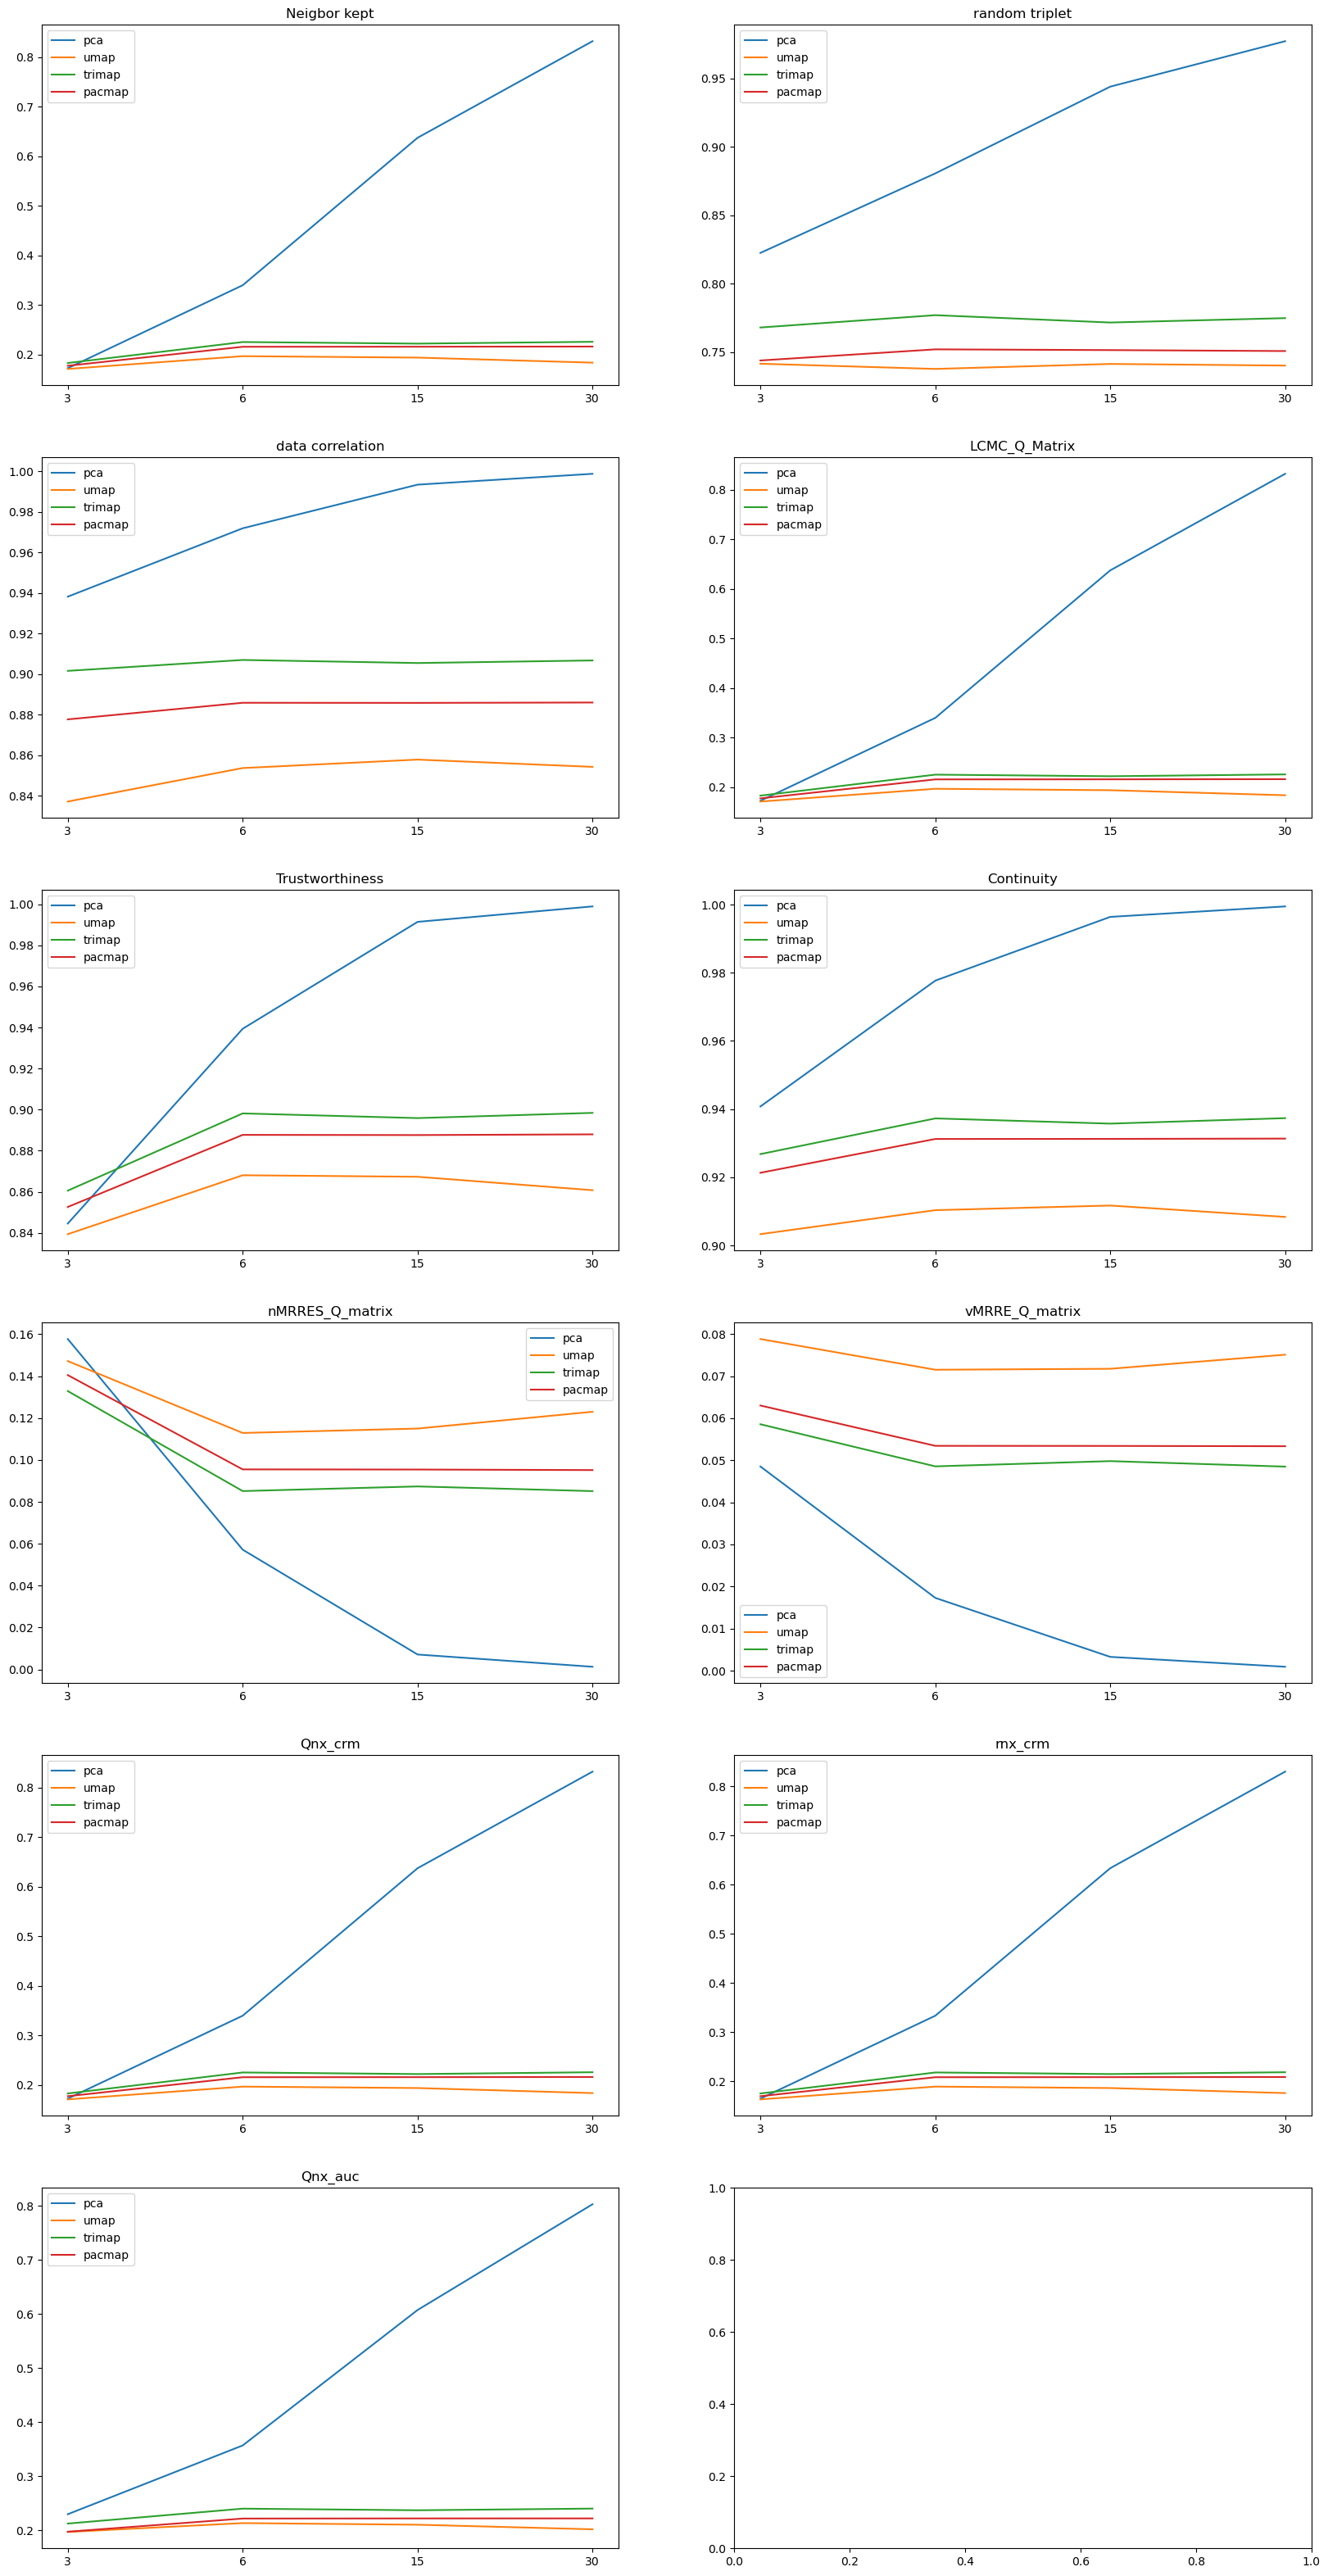

In [232]:
import re

fig, ax = plt.subplots(6,2,figsize = (20,40))

labels = ['pca','umap','trimap','pacmap']

for n,performances in enumerate([performance_dict_pca,performance_dict_umap,performance_dict_trimap,performance_dict_pacmap]):
    perf_to_plot = None
    for key,value in performances.items():
        if perf_to_plot == None:
            perf_to_plot = {k[0]:[] for k in value}
            perf_to_plot.update({'n_dims':[]})
        for metric,score in value:
            perf_to_plot[metric].append(score)
        perf_to_plot['n_dims'].append(re.search(r"\d+",key).group())
        
    i,j = 0,0

    for metric in perf_to_plot.keys():
        if metric != "n_dims":
            ax[j,i].plot(perf_to_plot['n_dims'],perf_to_plot[metric], label = labels[n])
            ax[j,i].legend()
            ax[j,i].set_title(metric)
            j = j+1 if i == 1 else j
            i = 0 if i == 1 else 1
            

### KMeans Clustering 